# Notebook for biophysically realistic AdEx mean-field model for reward-driven consequential decision-making
by Emre Baspinar, CNRS, NeuroPSI, Laboratory of Computational Neuroscience, Paris-Saclay

This notebook contains the implementation of our bicolumnar extended AdEx mean-field model proposed for a reward-driven consequential decision-making task. This Python notebook was prepared by Emre Baspinar, and its related manuscript is joint work of Emre Baspinar, Gloria Cecchini (U. of Barcelona), Michael DePass (U. of Barcelona), Ignasi Cos (U. of Barcelona), Rubén Moreno Bote (Pompeu Fabra University, Barcelona) and Alain Destexhe (CNRS, NeuroPSI, Paris-Saclay). See [[4]](https://drive.google.com/file/d/1qU4tm7z2MkStODW8mDp-bRb-hdWNB2hh/view) for more information. 

This notebook is updated regularly. Please feel free to contact if you have any feedback.

Contact: emre.baspinar@cnrs.fr 

## Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import scipy.io
# import operator
from SDEIntegrator import RegulatoryPsi, TimeStepping
from NeuronConnectivity import ReformatSynParameters, LoadTransferFunctions

## Introduction
Our model contains two pools where each pool is composed of an excitatory and an inhibitory population. Each population is modeled as a mean-field adaptive exponential integrate-and-fire (AdEx) model, which was derived in [1] from the AdEx network model [2] by following the *master equation formalism* [3, 4], by including adaptive dynamics as well. This model was proposed for only one excitatory and one inhibitory population, that is, for only one pool. We extend this model to a double pool architecture, where now also cross connections and correlations between the cross-populations must be considered. The challenge, besides the increased dimension of the mean field model, is to implement the cross-connections between the pools, since it requires the derivatives of cross-population covariances. Yet, it allows to take into account biophysical mechanisms which involve in the decision making process and which were not taken into account previously.

## Experimental task
Experimental task was applied on healthy human subjects. Each session consists of a number of episodes. Each episode is composed of a fixed number of trials. The number of trials are determined by the horizon number. If it is 0, then we have 1 trial per episode, and if it is 1, we have 2 trials per episode. In each trial, the subject is asked to choose between two stimuli, of which each one is a partially filled vertical bar. The amount of the filling is different for each bar. The total height of the bars are identical. Depending on the choice the subject makes and the implemented strategy for every episode, the subject has a reward or loss for the next trial. The reward is a fixed amount of gain added to the filled parts of both stimuli, and the loss  is the same amount of gain subtracted from the filled parts of both stimuli. Each bar is located either on the right hand side or on the left hand side of the screen, and their positions might be randomly exchanged between two trials. The sum of the chosen stimuli with the reward or the loss obtained at the end of each trial of each episode is accepted as the total result of the episode. More precisely, if we denote the chosen stimulus plus the reward or loss at the end of the $i$th trial by $A_i$, then the total result of an episode with $N\in \mathbb{Z}$ trial is
\begin{equation}
\text{Total reward} = \sum\limits_{i=0}^N = A_i. 
\end{equation}
The goal of the subject is to maximize the total result in each episode, that is, to be rewarded as many times as possible in each episode by making decisions in accordance with the implemented strategy. The behavioral performance of the subject is scored at the end of each episode as a scaled measure of the total reward between 0 and 1.

| 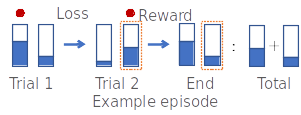 |
|:--:|
| <b>Fig. 1: Example episode with 2 trials. Implemented strategy is to choose small and large stimuli in the first and second trials, respectively. Subject makes the bad choice in the first trial and receives a loss. In the second she/he makes the good choice, thus receives a reward. The total result is the sum of the chosen stimuli (after their reward or loss), which are highlighted by the orange dashed rectangles. Corresponding performance results is the total result normalized by the sum of the stimuli corresponding to the maximum total result, i.e., by the double rewarded total result. </b> |

## Double-column AdEx mean field model 
Departure point of this study is the AdEx mean-field model which was proposed in [1]. We extend to a bicolumnar setting the model equations and the simulation framework provided in [1], which was for only a single cortical column.

The extended model equations are as follows:
\begin{equation}
\begin{split}
T \partial_t v_\alpha & = (F_\alpha -v_\alpha) + \frac{1}{2} C_{\xi\eta}\partial_{\xi\eta}F_\alpha +\sigma \omega_\alpha\\
T\partial_t C_{\alpha\beta} & =\delta_{\alpha\beta}A_{\alpha\alpha} + (F_\alpha-v_\alpha)(F_\beta-v_\beta) + C_{\beta\xi}\partial_\xi F_\alpha + C_\alpha\xi\partial_\xi F_\eta-2 C_{\alpha\beta}\\
\partial_t W_\alpha & = -\frac{W_\alpha}{\tau_w} + (\delta_{\alpha e_A}+\delta_{\alpha e_B})(b v_\alpha + a(\mu_V(v_{e_A}, v_{e_B}, W_\alpha) - E_L)),\hspace{12cm}(1)
\end{split}
\end{equation}
where
\begin{equation}
\begin{split}
F_{e_A}=F_{e_A}(\tilde{v}_{e_A}, \tilde{v}_{i_A}, W_{e_A}), & \quad\quad
F_{i_A}=F_{e_A}(\tilde{v}_{e_A}, \tilde{v}_{i_A}, W_{i_A}),\\
F_{e_B}=F_{e_B}(\tilde{v}_{e_B}, \tilde{v}_{i_B}, W_{e_B}), &\quad\quad
F_{i_B}=F_{e_A}(\tilde{v}_{e_B}, \tilde{v}_{i_B}, W_{i_B}),
\end{split}
\end{equation}
are the population transfer functions with the corresponding population indicated as subindex and where $\omega_\alpha=w_\alpha(t)$ is a white Gaussian noise generated independently for each time instant and for each population. More precisely,
$$
\mathbb{E}[\omega_\alpha(t)]=0,\;\text{for all}\; t\geq 0,\quad\text{and}\quad \mathbb{E}[\omega_\alpha(t) \omega_\beta(t^\prime)]=\delta_{\alpha\beta}\delta_{tt^\prime}.
$$
Here $\sigma>0$ shows the noise intensity level. Function $A_{\alpha\beta}$ is defined in [1] as follows:
$$
A_{\alpha\beta}=\delta_{\alpha\beta}\frac{N_\alpha}{F_\alpha(1/T-F_\beta)},
$$
with $N_\alpha$ denoting the number of neurons in population $\alpha$. Here $T$ is the time scale parameter both for the firing rate and for the covariance variables appearing in (1). We refer to [Section 2.3.1, 1] for a detailed explanation of $\mu_V$ appearing in the last line of (1). The time dependency of the terms are tacitly understood from (3). We use the notation given by $\partial_\alpha = \frac{\partial}{\partial v_\alpha}$ and $\partial_{\alpha\beta} = \frac{\partial^2}{\partial {v_\alpha}\partial_{v_\beta}}$ for the partial derivatives.  Here $\delta$ is the Dirac delta function, $E_L$ is a constant representing the reversal leakage potential, and finally $\tau_w$ is a time scale-like parameter for $W_\alpha$. The latter determines the evolution time scale of $W_\alpha$ approximately. We denote the total excitatory input firing rate for each transfer function by using the tilde notation. We express the probability of cross-connections with $p_c$. Cross-connections are always from excitatory populations, therefore, $p_c$ can be thought of as the ratio of exciatory neurons to the total number of neurons in the whole double pool network. Then we write the total excitatory input firing rates for the transfer functions as follows:
\begin{equation}
\begin{split}
\tilde{v}_{e_A}(t)  & =  v_{e_A}(t)+   v_{\text{AI}}+  \lambda^A_{w_r}(v_A(t), v_B(t))+w^e_c \Big ( v_{e_B}(t) + v_{\text{AI}}+\lambda^B_{w_r}(v_A(t), v_B(t), t) \Big )  p_c N_{e_B},\\ 
\tilde{v}_{i_A}(t)  & =  v_{i_A}(t)+  \lambda^A_{w_r}(v_A(t), v_B(t)) + w^i_c \Big ( v_{e_B}(t) + v_{\text{AI}}+\lambda^B_{w_r}(v_A(t), v_B(t), t) \Big )  p_c N_{e_B},\\
\tilde{v}_{e_B}(t)  & =  v_{e_B}(t) +  v_{\text{AI}}+\lambda^B_{w_r}(v_A(t), v_B(t))+ w^e_c \Big ( v_{e_A}(t) + v_{\text{AI}}+\lambda^A_{w_r}(v_A(t), v_B(t)) \Big ) p_c N_{e_A},\\
\tilde{v}_{i_B}(t)  & =  v_{i_B}(t)+  \lambda^B_{w_r}(v_A(t), v_B(t)) + w^i_c \Big ( v_{e_A}t)+v_{\text{AI}}+\lambda^A_{w_r}(v_A(t), v_B(t), t) \Big ) p_c N_{e_B},\hspace{10cm} (2)
\end{split}
\end{equation}
where $\lambda$ represents the firing rate of the regulatory pool, which is explained in the next section. In (3), all terms for which the time dependency is not explicit are constants.

| 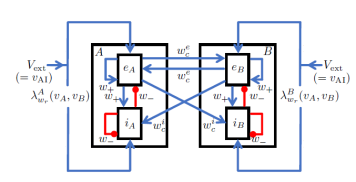 |
|:--:|
| <b>Fig. 2: Mean-field model. Each cortical column is represented as one pool of excitatory ($e_A$, $e_B$) and inhibitory ($i_A$, $i_B$) neuronal populations. Excitatory (blue) and inhibitory (red) in-pool connection weights are denoted by $w_+=w_-=1$, respectively. Cross-pool connections model intercolumnar long range connections in the prefrontal cortex, thus they are only excitatory. The cross-pool connections towards excitatory and inhibitory populations are weighted by $0<w_c^e=w_c^i<1$. Here $V_{\text{ext}}=v_{\text{AI}}$ represents the based-drive potential keeping the model in the asynchronous irregular (awake) state. Finally, $\lambda$ represents the regulatory mechanism introducing the bias to the input stimuli as explained in the next section.</b> |

## Regulatory mechanism

We interpret $v_A$ and $v_B$ as the stimuli with large quantity sample and the small quantity sample, respectively. In the experiment task conducted on human subjects, one of them appears on the left hand side of the screen and the other one appears on the right hand side. Those positions of the stimuli might be shuffled at each trial. The decision is made for choosing either $v_A$ or $v_B$, and it depends mostly on the regulatory pool. The regulatory pool weights both stimuli in accordance with the decision to be made. In this way, it promotes one of the stimulus, making more likely that the pool sensitive to the promoted stimulus has a higher firing rate compared to the firing rate of the other pool. This results in that the pool with the higher firing rate dominates the other pool and the decision is made for the promoted stimulus. We find the time instant where the decision is made as the moment where the difference between the firing rates of the excitatory populations of two pools exceeds a prefixed value. 

We model the regulatory pool evolving during the $i$th trial of the $E$th episode in terms of the following stochastic differential system:
\begin{equation}
\begin{cases}
\tau_\psi \frac{d\psi^E_i(t)}{dt} = -4 \psi^E_i(t) \Big ( \psi^E_i(t)-1 \Big )\Big ( \psi^E_i(t)-1/2 \Big )+\frac{\sigma_r}{(c_0 t)^2}\zeta_i\\
\psi_i^E(0)= \phi^{E-1}_i,\hspace{15cm}(2)
\end{cases}
\end{equation}
where $\tau_\psi$ is the time scale parameter, $\psi$ is the firing rate of the regulatory pool evolving in time independently for each trial, $\zeta_i = \zeta_i(t)$ is white Gaussian noise whose intensity level is determined by a temporally scaled version of $\sigma>0$, and finally $c_0>0$ is a constant. Here $E$ and $i$ denote the episode number and the trial number within the corresponding episode, respectively. The time dependent denominator appearing in front of this noise term introduces a strong stochastic behavior to the regulatory pool at the beginning of its corresponding trial, and this allows us to take into account that the system learns the strategy by exploring it initially over the episodes. Moreover, $c_0$ determines how much the model has the flexibility to deviate from the captured strategy once it learns the strategy. This is important to model the deviations occurring due to either perceptual difficulty to distinguish two stimuli or the human factor which makes the subject sometimes not follow the strategy to explore what happens. The evolution process (2) is restarted at the beginning of each trial by setting the initial condition to the value determined by the reward $\phi^E_i$ (to be explained later) corresponding to the same trial but of the precedent episode, i.e., of the $(E-1)$th episode. In this way, the reward mechanism provides for each trial a feedback to the regulatory pool at the end of the $(E-1)$th episode. This feedback determines towards which decision the regulatory pool will be biased in each trial of the $(E-1)$th episode. The final time of the evolution given by (2) is the final time of each trial and it is the same for every trial.

 
The regulatory pool activation is transmitted to Pool $A$ and Pool $B$ populations via $\lambda$ function appearing in (2). Its explicit form is given by
\begin{equation}\label{eq:lambdaExpression}
\begin{split}
\lambda^A_{w_r}(v_A(t), v_B(t), t) = & \psi\,v_A(t) + w_r(1-\psi(t))\,v_B(t),\\
\lambda^B_{w_r}(v_A(t), v_B(t), t) =  & \psi\,v_B(t) + w_r(1-\psi(t))\,v_A(t),
\end{split}
\end{equation}
where $w_r$ is a constant (which we choose to be 1 for now).

## Parameters and initial conditions
Please refer to [1] for more details about the parameters. Here we set the parameters in a way that the model is always in asynchronous irregular (AI) state, which is the awake state. We focus on rather AI state here, but it is possible to set the model to up-and-down state (sleep/anesthesia state) by changing the parameters; see [1] for proper parameters corresponding to up-and-down state. *Note: Do not forget to choose if SI units are considered or not! Note that the preset parameters given below are without SI units!*

In [2]:
# AdEx system parameters

siUnits=int(input("Biophysical parameters without --> 0 or with --> 1 SI units?"))

if siUnits==0:

    ## without SI units (in the poster-paper, we use without SI units)
    aRS, bRS, aFS, bFS, tauwRS, tauwFS = 4, 40, 0, 0, 5000, 1e9 # a, b and tauw parameters of adaptation mechanism for RS and FS cells
    Ntot   = 20000           # total number of neurons in the corresponding network
    pc     =  0.80           # ratio: Ne/Ntot, where Ne is the number of excitatory cells (RS cells)
    Ne     = Ntot * pc/2     # number of excitatory cells in one pool (RS cells)
    Ni     = Ntot * (1-pc)/2 # number of inhibitory cells in one pool (FS cells)
    vAI    = 5               # base potential keeping the population pairs in asynchronous irreguler (AI) state (awake state) 
    wce    = 2.5e-4          # cross-connection weight from excitatory to excitatory population
    wci    = 2.5e-4          # cross-connection weight from excitatory to inhibitory population
    sigma  = 0.01            # intrinsic noise level (for the noise appearing in firing rate equations in (1))
    El     = -65             # reversal leakage potential 
    Qe, Qi = 1.5, 5          # excitatory and inhibitory quantal conductances
    Te, Ti = 5, 5            # decay (refractory) time scale of excitatory and inhibitory synapses
    Gl     = 10              # leak conductance
    Ee, Ei = 0, -80          # excitatory and inhibitory reversal potentials
    tF, dt = 15, 0.05        # final time and time step of the time integration via Euler-Maruyama
    T = 5                    # time scale for the fast variables
    tauPsi = T               # time scale of the regulatory mechanism
    sigma_r = 0.01           # Extrinsic noise level (noise in the regulatory mechanism)
    c0      = 1.0            # c0 constant determining the decay rate of the extrinsic noise

elif siUnits==1:

    ## with SI units
    aRS, bRS, aFS, bFS, tauwRS, tauwFS = 4e-9, 40e-12, 0, 0, 5, 1e6 # a, b and tauw parameters of adaptation mechanism for RS and FS cells
    Ntot   = 20000           # total number of neurons in the corresponding network
    pc     =  0.80           # ratio: Ne/Ntot, where Ne is the number of excitatory cells (RS cells)
    Ne     = Ntot * pc/2     # number of excitatory cells in one pool (RS cells)
    Ni     = Ntot * (1-pc)/2 # number of inhibitory cells in one pool (FS cells)
    vAI    = 5               # base potential keeping the population pairs in asynchronous irreguler (AI) state (awake state) 
    wce    = 2.5e-4          # cross-connection weight from excitatory to excitatory population
    wci    = 2.5e-4          # cross-connection weight from excitatory to inhibitory population
    sigma  = 0.01            # intrinsic noise level (for the noise appearing in firing rate equations in (1))
    El     = -65e-3          # reversal leakage potential 
    Qe, Qi = 1.5e-9, 5e-9    # excitatory and inhibitory quantal conductances
    Te, Ti = 5e-3, 5e-3      # decay (refractory) time scale of excitatory and inhibitory synapses
    Gl     = 10e-9           # leak conductance
    Ee, Ei = 0, -80e-3       # excitatory and inhibitory reversal potentials
    tF, dt = 6, 0.05         # final time and time step of the time integration via Euler-Maruyama
    T = 5e-3                 # time scale for the fast variables
    tauPsi = 10*T            # time scale of the regulatory mechanism
    sigma_r = 0.01           # Extrinsic noise level (noise in the regulatory mechanism)
    c0      = 45             # c0 constant determining the decay rate of the extrinsic noise


# We gather all parameters together in the vector "params"
params = np.zeros(28)
params[0]  = aRS
params[1]  = bRS
params[2]  = aFS
params[3]  = bFS
params[4]  = tauwRS
params[5]  = tauwFS
params[6]  = Ntot
params[7]  = pc
params[8]  = Ne
params[9]  = Ni
params[10] = vAI
params[11] = wce
params[12] = wci
params[13] = sigma
params[14] = El
params[15] = Qe
params[16] = Qi
params[17] = Te
params[18] = Ti
params[19] = Gl
params[20] = Ee
params[21] = Ei
params[22] = tF
params[23] = dt
params[24] = T
params[25] = tauPsi
params[26] = sigma_r
params[27] = c0

Biophysical parameters without --> 0 or with --> 1 SI units? 0


We set initial conditions ad hoc to the decision-making task which we consider.

In [3]:
# Initial conditions for state variables
v0  = 1.      # v_eA            : V[0]
v1  = 30.     # v_iA            : V[1]
v2  = 0.5     # C_eAeA          : V[2]
v3  = 0.5     # C_eAiA = C_iAeA : V[3]
v4  = 0.5     # C_iAiA          : V[4]
v5  = 1.e-10  # W_eA            : V[5]
v6  = 0.      # W_iA            : V[6]
v7  = 1.      # v_eB            : V[7]
v8  = 30.     # v_iB            : V[8]
v9  = 0.5     # C_eBeB          : V[9]
v10 = 0.5     # C_eBiB          : V[10]
v11 = 0.5     # C_iBiB          : V[11]
v12 = 1.e-10  # W_eB            : V[12]
v13 = 0.      # W_iB            : V[13]
v14 = 0.05    # C_eAeB          : V[14]
v15 = 0.05    # C_eAiB          : V[15]
v16 = 0.05    # C_iAeB          : V[16]
v17 = 0       # C_iAiB          : V[17]

psi0 = 0.5   # initial condition for the regulatory mechanism at the beginning of the first trial in each episode

V0 = [v0, v1, v2, v3, v4, v5, v6, v7, v8,\
      v9, v10, v11, v12, v13, v14, v15, v16, v17] 

## Single-trial simulation setup
We first initialize the stimuli A and B, in a way that one of them is weaker in comparison to the other.

In [4]:
# Define the stimuli for one trial
from scipy.special import comb

def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

t = np.linspace(0, tF, int(tF/dt)+1) # define the whole time interval


ampA = 1    # amplitude of stimulus A
ampB = 10   # amplitude of stimulus B
t0 = 2 # initial time instant of the stimuli


stimulusA = ampA*(smoothstep(t-t0)-smoothstep(t-t0-tF))
stimulusB = ampB*(smoothstep(t-t0)-smoothstep(t-t0-tF))

Here we load the transfer functions which were derived for both regularly spiking (RS, excitatory) and fast spiking (FS, inhibitory) neural populations via the semi-analytical approach given in [4]. Once they are loaded, we can run a one-trial simulation.

In [5]:
## Build the simulation setup: load the transfer functions for both RS & FS populations
TF1, TF2 = LoadTransferFunctions('RS-cell', 'FS-cell', 'CONFIG1')
lambdaA, lambdaB, psi = RegulatoryPsi(psi0, stimulusA, stimulusB, params) # generate the regulated stimuli for the trial

# Time integration for one single trial
state = TimeStepping(V0, lambdaA, lambdaB, TF1, TF2, params)

Now we can plot the evolution of firing rates of excitatory populations in  both A and B pools. Those plots are example of one trial simulations, in which the reward is not included yet. The population which wins the competition makes the decision in favor of the stimulus which it is selective to. We say that the population having the higher firing rate wins the competition when the difference betweenthe firing rates exceed a certain threshold. The threshold is arbitrary and fixed to a constant at the beginnning of the whole experiment session. In the next step we will consider multiple episodes, where each epsiode contains one trial. In those simulations, we will introduce also the reward mechanism.

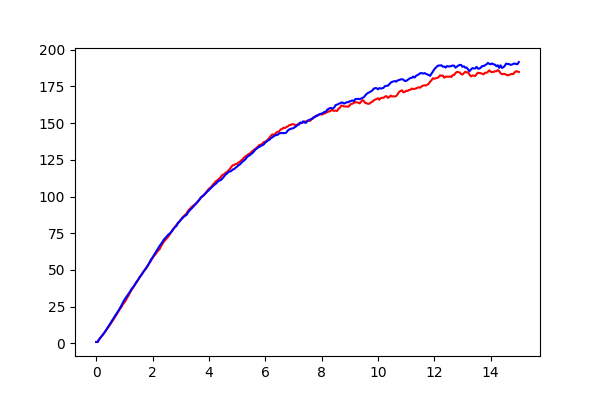

In [6]:
%matplotlib widget
# Plot Pool A (red) and B (blue) excitatory population firing rates
plt.figure(figsize=(6, 4))
plt.plot(t, state[:, 0], 'r') # plotting v_{eA} (red)
plt.plot(t, state[:, 7], 'b') # plotting v_{eB} (blue)
# plt.margins(x=0.001, y=-0.001)

Now it is time to introduce the reward mechanism. This will allow us to extend our simulation framework to multiple episodes, where each episode contains one (Horizon 0) or two (Horizon 1) trials, depending on which horizon we would like to study.

## Reward mechanism
Reward mechanism is the key module introducing an online learning to the model. It allows the model to capture the strategy maximizing the gain through each episode. Once the strategy is learned, the system makes the decisions in the way which maximizes the final gain, which is the total reward of one episode. This is the key mechanism endowing the model with working memory. 

Reward mechanism is updated through a discrete evolution where the temporal variable is the trial number. In other words, the reward function value remains constant during a trial and it is updated at the end of the trial. This updated value at the end of the trial is fed to the same trial corresponding to the episode coming after as the initial condition of the regulatory function $\psi$; see Eq. (2). We use the notation $M^E_i$ to denote the mean value of the stimuli corresponding to $i$the trial of the $E$th episode. We write $N$ with $N-1$ expressing the number of the last trial in one episode to refer to the total reward obtained at the end of the episode, although $N$th trial does not exist. Then we write the evolution for the reward function $\phi$ as follows:
\begin{equation}\label{eq:rewardMechanismEqn}
\begin{cases}
\phi^{E+1}_i =   \phi^E_i + k  ( M^E_{i+1} - M^E_i ) (2\psi_i^E(T)-1)(\phi^E_i  -1 )^2(\phi_i^E)^2,\\
\phi^0_i = C,\quad \text{for all}\quad i\in \{0, 1,\dots, N-1  \},\quad\quad\quad\quad\quad\quad\quad\quad\quad (3)
\end{cases}
\end{equation}
with $C$ denoting a constant, which is fixed to $0.5$ for the first episode in our framework. This system initiates the reward mechanism for each trial series over the episodes separately, yet the trials are not independent due to the coupling effect arising from $( M^E_{i+1} - M^E_{i})$ factor.

Reward mechanism is implemented as given below, in an integrated way to the simulation setup.

## Model in action: simulations

Each simulation session is composed of a certain number (nOfEpisodes) of episodes. Here we fix nOfEpisodes to 5 for simplicity although in our simulations we use higher values (e.g., 130). In Horizon 0, each episode has one single trial. In Horizon 1, each episode has two trials. Here the simulation is performed for Horizon 1 (nH=1), but it can be easily done for Horizon 0 as well by fixing nH to 0.

In [7]:
# Parameters for episode initializations
nOfEpisodes = 5 # number of episodes in the whole session
dSet = [0.01,0.05,0.1,0.15,0.2] # difficulty set of visual discriminization. NOTE: dMax must be less than gain!!! 
                                # difficulty is proportional to the difference between the amplitudes of the two stimuli
dMax = max(dSet) # max. value of the difficulty 
nH = 1 # horizon number: n. of trials per episode = nH + 1
gain = 0.3 # reward gain                    

if nH==0: 
    minStim = gain        # min. value of the stimuli (for Horizon 0)
    maxStim = minStim + 6 # max. value of the stimuli (for Horizon 0)
elif nH==1:
    minStim = 2 * gain    # min. value of the stimuli (for Horizon 1)
    maxStim = minStim + 6 # max. value of the stimuli (for Horizon 1)
    
reward = np.zeros((nH+1, nOfEpisodes)) # initialize reward list
decisionThreshold = 5 # the decision is made once the absolute value of the difference between excitatory population firing rates exceeds this value.

# Initialize the vectors which store the recorded results
performance = np.zeros(nOfEpisodes) # performance vector saving performance results of each episode
decisionTimeList = np.zeros(nOfEpisodes * (nH+1)) # vector saving the decision times of each trial
difficultyList = np.zeros(nOfEpisodes * (nH+1)) # vector saving the difficulty values used in each episodeNow it is time to introduce the reward mechanism. This will allow us to extend our simulation framework to multiple episodes with each episode containing one (Horizon 0) or two (Horizon 1) trials, depending on which horizon we would like to study.

We perform each simulation session for several times (nOfIterations) to be able to obtain statistics allowing us to quantify the behavioral results produced by the model framework and to compare them to the experimental data. We fit the model to the experimental data by tuning two parameters: learning speed ($k$ as given in Eq. (3)) and noise decay rate ($c_0$ as given in Eq. (2)). The user can chose one fixed value for either one of those two parameters and vary the other by assigning a vector of several value. 

In [8]:
# Iteration parameters
nOfIterations = int(input("Enter the number of iterations per each experiment session: ")) # number of how many times we perform each simulation session
fixedPar = int(input("Enter 0 to fix k (learning speed), enter 1 to fix c0 (decay rate): ")) # determine which parameter will be fixed and the other will be varied

if fixedPar==0:    
    learningSpeed=float(input("Enter fixed k (learning speed) value: "))
    # nc0Val=int(input("Number of c0 values: ")) # enter for how many values of c0 will be the experiment performed 
    c0List=list(map(float, input("Enter the c0 values: ").strip().split())) # Enter the values as, e.g., 1 2 5 7, without any comma in between
    lengthParameterList = len(c0List)
    nc0Val = lengthParameterList
elif fixedPar==1:
    c0=float(input("Enter fixed c0 (decay rate) value: "))
    # nkVal=int(input("Number of k values: ")) # enter for how many values of k will be the experiment performed 
    learningSpeedList=list(map(float, input("Enter the k values: ").strip().split())) # Enter the values as, e.g., 1 2 5 7, without any comma in between
    lengthParameterList = len(learningSpeedList)
    nkVal = lengthParameterList
    

Enter the number of iterations per each experiment session:  2
Enter 0 to fix k (learning speed), enter 1 to fix c0 (decay rate):  0
Enter fixed k (learning speed) value:  0.2
Enter the c0 values:  1.8 2


Now we can run the simulation for the values entered in the above code box. Results will be saved automatically to the notebook folder with the parameters noted in the title.

In [9]:
# Run the simulations by varying the parameter chosen in the previous command box
for parameterNo in range(lengthParameterList):
    iteration = 0
    
    if fixedPar==0:
        c0 = c0List[parameterNo] # to let the regulator have time to evolve, a bit ad hoc!
        params[27] = c0
    elif fixedPar==1:
        learningSpeed = learningSpeedList[parameterNo]
        params[27] = c0
             
    # Initiate the iteration
    for iteration in range(nOfIterations):
       
        # Keep the trace of which parameters are evaluated
        print("Processing for...")
        print("Parameter learning speed: ", learningSpeed)
        print("Parameter c0: ", c0)
        print("Iteration: ", iteration)

        # Set the initial reward for each horizon in the first episode
        for i in range(0, nH+1):
            reward[i][0] = 0.5 # set the initial reward to 0.5 (neutral value)

        # Simulate each episode
        for episodeNo in range(0, nOfEpisodes):
            
            d = dSet[random.randint(0,len(dSet)-1)] # assign randomly the difficulty for the current episode
            difficultyList[episodeNo] = d # save the difficulty of the current episode
            
            # Verify that the stimuli and rewards are compatible (to avoid negative stimuli etc.)
            lowest  =  minStim + d/2 + (nH+1)*gain # generated stimuli cannot be lower than this value
            highest = maxStim - d/2 - (nH+1)*gain # generated stimuli cannot be higher than this value
            mean0Val = np.random.uniform(lowest, highest) # initial mean of the stimuli
            minAchievable = mean0Val - d/2 - (nH+1)*gain # to check if this value is lower than "lowest" (Cond. A)
            maxAchievable = mean0Val + d/2 + (nH+1)*gain # to chech if this value is higher than "higher" (Cond. B)

            while (maxAchievable > maxStim) or (minAchievable < minStim): # if Cond. A or Cond. B, regenerate your stimuli
                print('Mean value is out of bounds! Regenerating the mean value...')
                mean0Val = np.random.uniform(lowest, highest)
                minAchievable = mean0Val - d/2 - (nH+1)*gain
                maxAchievable = mean0Val + d/2 + (nH+1)*gain


            saveDecision = np.zeros(nH+1) # initialize the decision vector, it will save which stimuli are chosen throughout the trials
            pointer = 0
            
            mean0ValInitial = mean0Val # store mean value for nH=1 simulations
            
            for trial in range(0,nH+1): # initiate the first trial of the current episode
                shuffle = np.random.randint(0,2) # to randomly shuffle the positions of two stimuli
                
                ampA = mean0Val - d/2 # weak stimulus amplitude
                ampB = mean0Val + d/2 # strong stimulus amplitude

                # Initialize the stimuli, and by shuffling them if "shuffle" is on
                if shuffle==1:
                    ampA_0 = ampA
                    ampA = ampB
                    ampB = ampA_0

                stimulusA = ampA*(smoothstep(t-t0)-smoothstep(t-t0-tF)) # weak stimulus (appears at t=2)
                stimulusB = ampB*(smoothstep(t-t0)-smoothstep(t-t0-tF)) # strong stimulus (appears at t=2)

                # Activity evolution (SDE system is integrated in time for each trial separately)        
                psi0=reward[trial][episodeNo] # set initial condition for the regulatory mechanism
                lambdaA, lambdaB, psi = RegulatoryPsi(psi0, stimulusA, stimulusB, params) # generate the regulated stimuli for the trial
                state = TimeStepping(V0, lambdaA, lambdaB, TF1, TF2, params)
                veA, veB = state[:, 0], state[:, 7]

                # Find the decision time
                diff = np.abs(veA - veB) # compute the difference between the excitatory populations
                diff2 = diff[int(2/dt):-1] # ignore the first instants of the trial since the activity is degenerate the beginning
                decisionIndex = np.where(diff2>decisionThreshold) # identify the time instant at which the decision is made (bicolumnar competition is assumed to end at this instant)   
                

                # Save the results and update the reward: learning the strategy through episodes
                if len(decisionIndex[0])>0:
                    decisionTime = (decisionIndex[0][0]) * dt # pick the first instant where the difference exceeds dec. threshold
                    decisionTimeList[episodeNo] = decisionTime
                    if episodeNo<nOfEpisodes-1:
                        if nH == 1:
                            if trial==0:
                                if psi[-1]<0.5:
                                    ampA = ampA + gain
                                    ampB = ampB + gain
                                    saveDecision[trial] = min(ampA, ampB)
                                    mean1Val = (ampA + ampB)/2 # mean after the gain
                                    reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                     learningSpeed*(mean1Val - mean0Val)*\
                                    (2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                    *(reward[trial][episodeNo])**2
                                    mean0Val = mean1Val # update mean value for the next trial
                                else:
                                    ampA = ampA - gain
                                    ampB = ampB - gain
                                    saveDecision[trial] = max(ampA, ampB)
                                    mean1Val = (ampA + ampB)/2 # mean after the gain                           
                                    reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                     learningSpeed*(mean1Val - mean0Val)*(2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                    *(reward[trial][episodeNo])**2
                                    mean0Val = mean1Val # update mean value for the next trial
                            elif trial==1:
                                if psi[-1]>0.5:
                                    ampA = ampA + gain
                                    ampB = ampB + gain
                                    saveDecision[trial] = max(ampA, ampB)                           
                                    mean1Val = (ampA + ampB)/2 # mean after the gain                           
                                    reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                     learningSpeed*(mean1Val - mean0Val)*(2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                    *(reward[trial][episodeNo])**2
                                    mean0Val = mean1Val # update mean value for the next trial
                                else:
                                    ampA = ampA - gain
                                    ampB = ampB - gain
                                    saveDecision[trial] = min(ampA, ampB)                
                                    mean1Val = (ampA + ampB)/2 # mean after the gain
                                    reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                     learningSpeed*(mean1Val - mean0Val)*(2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                    *(reward[trial][episodeNo])**2
                                    mean0Val = mean1Val # update mean value for the next trial
                        elif nH == 0:
                            if psi[-1]<0.5:
                                ampA = ampA + gain
                                ampB = ampB + gain
                                saveDecision[trial] = min(ampA, ampB)
                                performance[episodeNo] = 1   
                                mean1Val = (ampA + ampB)/2 # mean after the gain
                                reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                 learningSpeed*(mean1Val - mean0Val)*(2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                *(reward[trial][episodeNo])**2
                            else:
                                ampA = ampA - gain
                                ampB = ampB - gain
                                saveDecision[trial] = max(ampA, ampB)
                                performance[episodeNo] = 0
                                mean1Val = (ampA + ampB)/2 # mean after the gain
                                reward[trial][episodeNo+1] = reward[trial][episodeNo] +\
                                 learningSpeed*(mean1Val - mean0Val)*(2*psi[-1]-1)*(reward[trial][episodeNo]-1)**2\
                                *(reward[trial][episodeNo])**2
                    else:
                        pointer = 1
                        decisionTimeList[episodeNo] = -1

            # Save the final performance of the episode
            if pointer == 0:
                if nH == 1:
                    mxBound = 2*mean0ValInitial + 3*gain    
                    mnBound = 2*mean0ValInitial - 3*gain        
                    performance[episodeNo] = (sum(saveDecision)-mnBound)/(mxBound - mnBound)
                    if performance[episodeNo]>0.99:
                        performance[episodeNo]=1
                    elif performance[episodeNo]<0.01:
                        performance[episodeNo]=0
                    
                elif nH == 0:
                    '''DO NOTHING!'''

            elif episodeNo!=nOfEpisodes-1:
                print("Episode %1.0i is not valid!" % episodeNo)
                performance[episodeNo] = -1
                        
        learningSpeedSave2 = learningSpeed*1000 # define again to comply with indentation of Python
        c0Save = c0*1000
        performanceArray = np.array(performance)
        np.save("performanceResults_Iter_%d_k_%d_c0_%d.npy" % (iteration, learningSpeedSave2, c0Save), performanceArray)
        np.save("decisionTimeList_Iter_%d_k_%d_c0_%d.npy" % (iteration, learningSpeedSave2, c0Save), decisionTimeList)
        np.save("difficultyList_Iter_%d_k_%d_c0_%d.npy" % (iteration, learningSpeedSave2, c0Save), difficultyList)      

print('Simulation is over.')

Processing for...
Parameter learning speed:  0.2
Parameter c0:  1.8
Iteration:  0
Processing for...
Parameter learning speed:  0.2
Parameter c0:  1.8
Iteration:  1
Processing for...
Parameter learning speed:  0.2
Parameter c0:  2.0
Iteration:  0
Processing for...
Parameter learning speed:  0.2
Parameter c0:  2.0
Iteration:  1
Simulation is over.


If an episode is not valid (Episode X is not valid!), it means that there was no decision made in that episode. We ignore this episode in the performance results. Such cases model the experimental episodes in which the subject makes no decision within in the given time duration or makes decision before the authorized period of time and so on. This is why we usually simulate more episodes than we need, in this way we can eliminate the invalid episodes and use the ones ending up with a decision for our analysis. 

## Case study 1: changing noise decay rate $c_0$
Noise decay rate $c_0$ appears in time evolution Eq. (2) of the regulatory mechanism, and it determines how much the model has the flexibility to deviate from the strategy which it captures. This flexibility models both the perceptual difficulties that the human subject undergoes in the experimental task and the exploratory nature of the subject which sometimes makes the subject to deviate from the strategy which the subject alread captured on purpose in order to explore, see what happens in such cases of deviation.

Here we will have a look at how global measures of simulation performance results change with varying $c_0$. We fix $k=0.2$. Performance results are scaled between 0 and 1, with 0 denoting the worst case performance and 1 denoting the best case performance. In the best case, the decisions are made in complete agreement with the implemented strategy. In the worst case, there is no decision made in agreement with the implemented strategy. In the all cases in between, there is a partial overlap with the made decisions and the implemented strategy.

We define the following global measures to quantify the performance results:

**Performance deviation:** A performance deviation is a point with a performance lower than 1 in the set of performance samples. 

**Deviation cluster:** A deviation cluster is a set of <u>at least</u> 3 successive performance deviations with respective to the episode numbers.

**Performance cluster:** Performance cluster is the set of performance samples in which there is no deviation cluster and whose last performance sample is also the last sample of the whole experiment.

**In-cluster deviation:** A performance deviation is called in-cluster if it occurs in a performance cluster.
Two measures are particularly important to quantify the behavioral performance in terms of strategy learning and flexibility of the model. Those are performance cluster, since it gives at which episode the model/subject captures the implemented strategy; and in-cluster deviation, since it provides information about how much flexible the model/subject is after capturing the strategy.

We will consider only Horizon 0 simulations for the sake of simplicity, i.e., we have only one trial for each episode. Let us first load the performance data which was produced by using the same routine given in the previous section.

SIMULATION FOR c0: 1.0


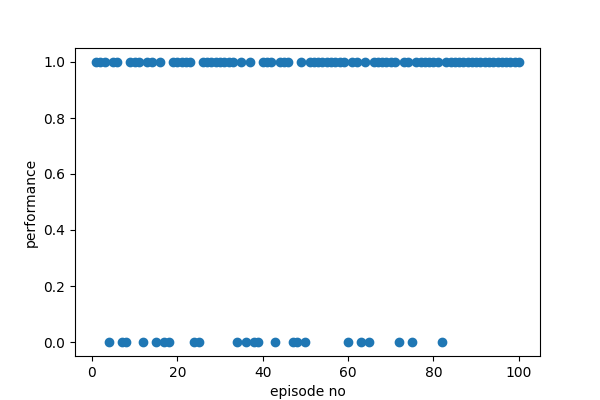

Episode numbers SIMULATION cluster gaps: (array([ 3,  6,  7, 11, 14, 16, 17, 23, 24, 33, 35, 37, 38, 42, 46, 47, 49,
       59, 62, 64, 71, 74, 81]),)
Number of performance deviations: 23
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 23



SIMULATION FOR c0: 1.1


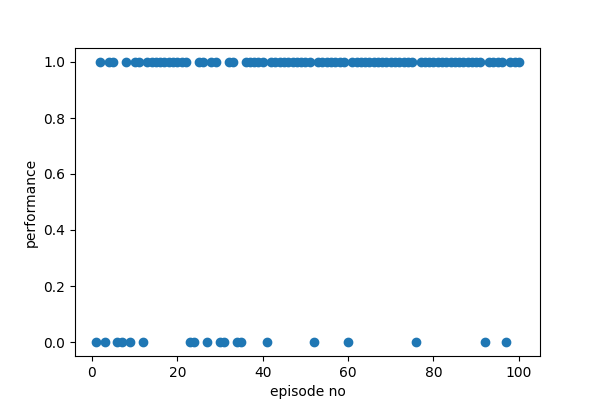

Episode numbers SIMULATION cluster gaps: (array([ 0,  2,  5,  6,  8, 11, 22, 23, 26, 29, 30, 33, 34, 40, 51, 59, 75,
       91, 96]),)
Number of performance deviations: 19
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 19



SIMULATION FOR c0: 1.2


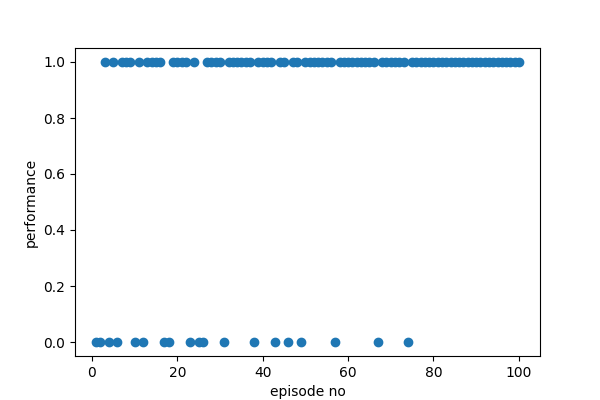

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  3,  5,  9, 11, 16, 17, 22, 24, 25, 30, 37, 42, 45, 48, 56,
       66, 73]),)
Number of performance deviations: 19
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 19



SIMULATION FOR c0: 1.3


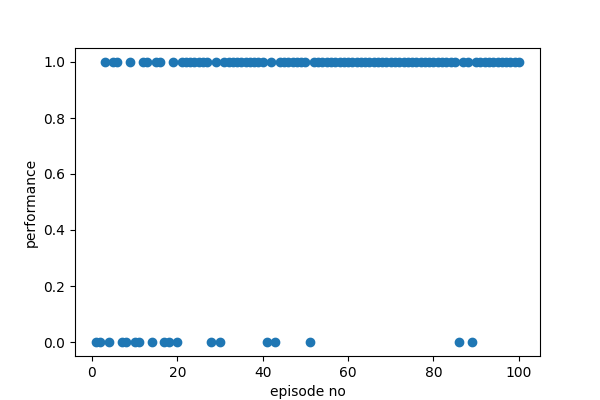

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  3,  6,  7,  9, 10, 13, 16, 17, 19, 27, 29, 40, 42, 50, 85,
       88]),)
Number of performance deviations: 18
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 18



SIMULATION FOR c0: 1.4


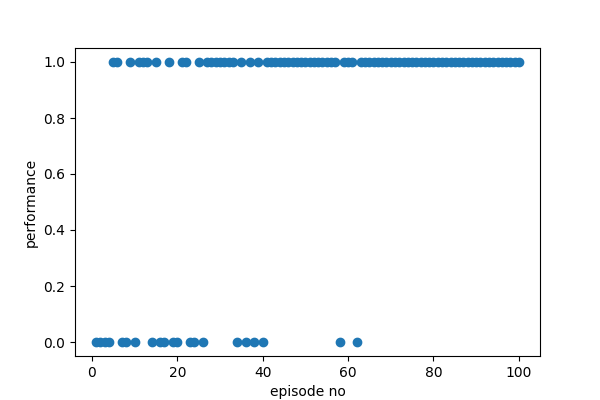

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  2,  3,  6,  7,  9, 13, 15, 16, 18, 19, 22, 23, 25, 33, 35,
       37, 39, 57, 61]),)
Number of performance deviations: 21
Initial episode number of performance block: 3
Number of in-cluster performance deviations: 17



SIMULATION FOR c0: 1.5


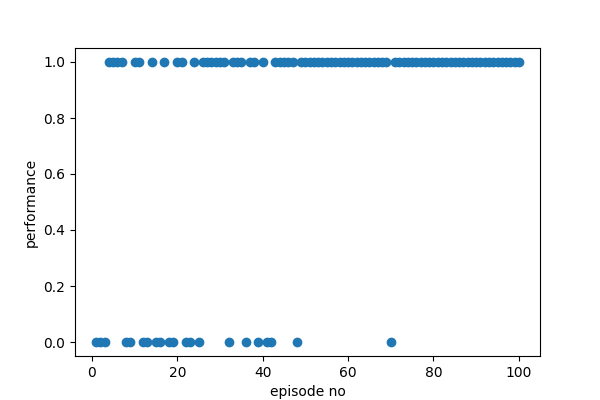

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  2,  7,  8, 11, 12, 14, 15, 17, 18, 21, 22, 24, 31, 35, 38,
       40, 41, 47, 69]),)
Number of performance deviations: 21
Initial episode number of performance block: 2
Number of in-cluster performance deviations: 18



SIMULATION FOR c0: 1.6


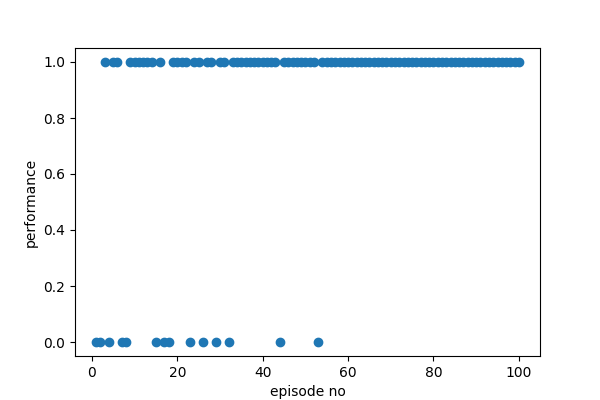

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  3,  6,  7, 14, 16, 17, 22, 25, 28, 31, 43, 52]),)
Number of performance deviations: 14
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 14



SIMULATION FOR c0: 1.7


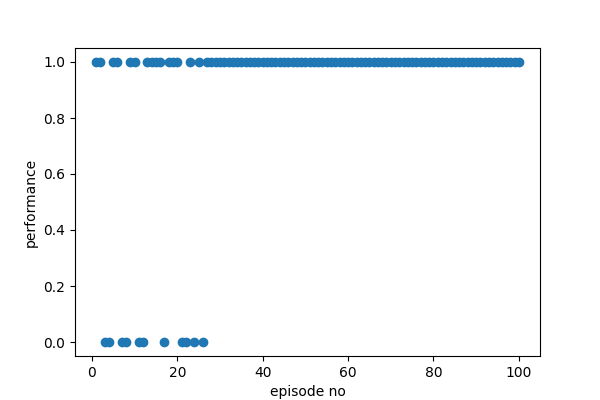

Episode numbers SIMULATION cluster gaps: (array([ 2,  3,  6,  7, 10, 11, 16, 20, 21, 23, 25]),)
Number of performance deviations: 11
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 11



SIMULATION FOR c0: 1.8


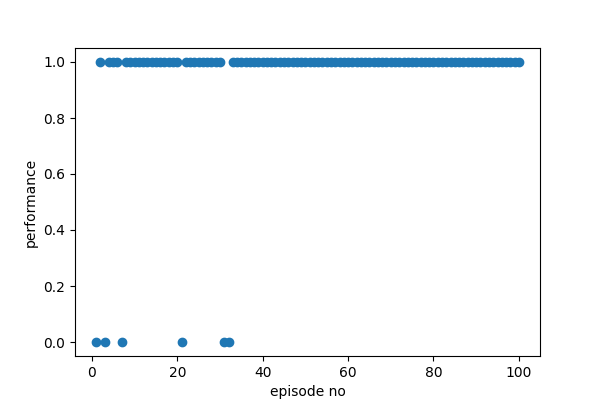

Episode numbers SIMULATION cluster gaps: (array([ 0,  2,  6, 20, 30, 31]),)
Number of performance deviations: 6
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 6



SIMULATION FOR c0: 1.9


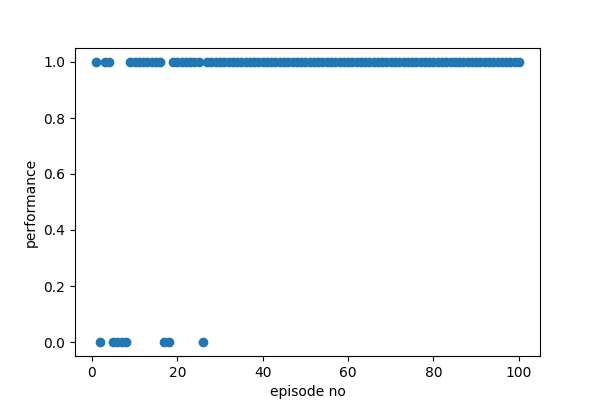

Episode numbers SIMULATION cluster gaps: (array([ 1,  4,  5,  6,  7, 16, 17, 25]),)
Number of performance deviations: 8
Initial episode number of performance block: 7
Number of in-cluster performance deviations: 3





In [ ]:
notebook_path = os.path.abspath("MainNotebook.ipynb") # find the actual path of the Python notebook

# Define "deviations" finding the first and the last episode numbers of all performance deviation ranges
def deviations(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

# Set the total number of episodes in each simulation
nOfEpisodes = 100 # since in human experiments it is 100.
episodeAxis = np.linspace(1,nOfEpisodes,nOfEpisodes, dtype=int) # for the x axes of performance result plots

## Import the experimental data
# experimentData = scipy.io.loadmat('workspace_scriptGeneralH210528.mat')

## Load and arrange the experimental human performance data
# subject7 = experimentData['Performance'][0][6]
# subject7 = subject7[~np.isnan(subject7)]
# subject7 = subject7[(1 >= subject7) & (subject7 >= 0)]
# subject7 = subject7.flatten()
# subject7 = subject7[0:nOfEpisodes]

# Load the simulation performance data
c0Set = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9] # simulated c0 values

inClusterSet = [] # initialize an array to save number of in-cluster performance deviations for future plots

for c0Val in c0Set:
    c0Iter = c0Val*1000 # to avoid rounding in the title of the data file (only for Python convention)
    path = os.path.join(os.path.dirname(notebook_path), \
            "showcaseData/showcase_1_H0/varying_c0/performanceResults_Iter_0_k_200_c0_%d.npy" %c0Iter) # set the data file path

    simulationData = np.load(path) # load the simulation result of the corresponding c0
    simulationData = simulationData[0:nOfEpisodes] # take only the first 100 episodes!
    
    # Plot the performance results episode-by-episode
    print('SIMULATION FOR c0: %.1f' %c0Val)
    fig = plt.figure(figsize=(6,4))
    plt.scatter(episodeAxis, simulationData)
    plt.xlabel("episode no")
    plt.ylabel("performance")
    plt.show()
    
    
    # Episode numbers of the performance deviations...
    # print('Episode numbers of EXPERIMENT cluster gaps:', np.where(subject7 < 1)) #...of the human experiments
    print('Episode numbers SIMULATION cluster gaps:', np.where(simulationData < 1)) #...of the simulations
    print('Number of performance deviations:', len(np.where(simulationData < 1)[0])) # total number of performance deviations (simulations)
    
    deviationsAll = np.where(simulationData < 1) # performance deviation episode numbers
    devRanges = deviationsAll[0] # jsut for Python convention
    devRanges = deviations(devRanges) # performance deviation ranges to find deviation blocks (thus initial episode number of performance blocks)
    # print(devRanges) # the first and last episode numbers of deviation blocks
    
    # Arrange the performance deviation ranges
    firstEpisode = []
    lastEpisode = []

    for element in devRanges:
        firstEpisode.append(element[0]) # keep the first
        lastEpisode.append(element[1]) # keep the second
  
    # Find the last deviation block, the last episode number of this block is the initial episode number of the performance block
    devBlockIndices = list(np.where(np.subtract(lastEpisode, firstEpisode)>=2))
    
    # Check if there is any deviation block. If not, the whole experiment is actually a performance block! Save also the in-cluster performance deviations.
    if len(devBlockIndices[0]>0):
        initialPerformanceBlock = devBlockIndices[-1][0]
        devRanges = list(devRanges)
        initialPerformanceBlock = devRanges[initialPerformanceBlock][1]   
        numberOfInClusterDeviations = len(np.where(deviationsAll>initialPerformanceBlock)[0]) # find the number of in-cluster performance deviations
        inClusterSet.append(numberOfInClusterDeviations) # save the number of in-cluster performance deviations for future plots
        # Print now also the initial episode number of the performance blocks
        print('Initial episode number of performance block:', initialPerformanceBlock)
        print('Number of in-cluster performance deviations:', numberOfInClusterDeviations)
    else:
        noDeviationBlock = len(np.where(simulationData < 1)[0][:])
        inClusterSet.append(noDeviationBlock)
        print('No deviation block! Performance block starts from the beginning.')
        print('Number of in-cluster performance deviations:', noDeviationBlock)
    

    print('')    
    print('')
    print('')


As expected, increasing $c_0$ results in a decreasing trend in the number of in-cluster deviations as can be seen in the following plot:

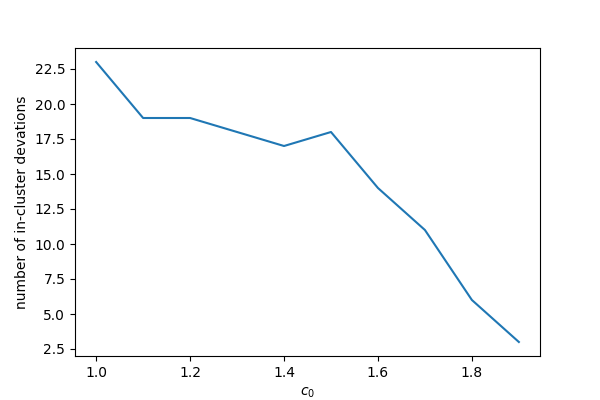

In [11]:
fig = plt.figure(figsize=(6,4))
plt.plot(c0Set, inClusterSet)
plt.xlabel("$c_0$")
plt.ylabel("number of in-cluster devations")
plt.show()

## Case study 2: changing learning speed $k$
Learning speed parameter $k$ appears in episode-based discrete evolution Eq. (3) of the reward mechanism. It determines (approximately) the initial episode number of the performance cluster, which was defined in Case study 1. In other words, it determines how fast the model captures the implemented strategy. Here we will see the effect of varying $k$, where we fix $c_0=2$.

An important remark is that the learning speed parameter is related to in-cluster deviations, although this relation is not explicit. In the cases where the initial episode number of performance cluster is too large, since the number of episodes for in-cluster deviations is not large, the effect of $c_0$ on the number of in-cluster episodes is outweighted by the effect of learning speed $k$. Therefore, extreme values for $k$ might produce misleading results in the simulations.

Here we perform the data obtained via the same type of simulations as in Case study 1, with the only difference of that now we fix $c_0$ and vary $k$. We consider only Horizon 0 case as before for the sake of simplicity.

SIMULATION FOR k: 0.05


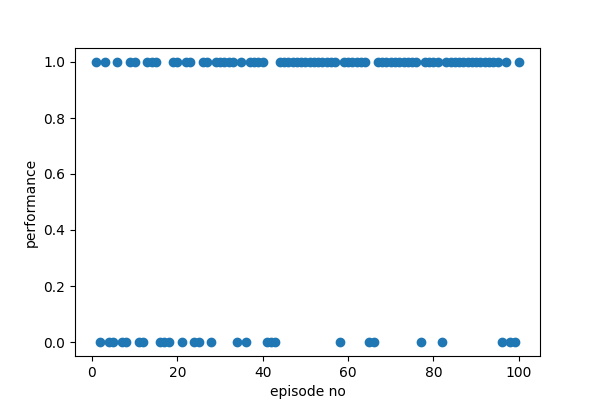

Episode numbers SIMULATION cluster gaps: (array([ 1,  3,  4,  6,  7, 10, 11, 15, 16, 17, 20, 23, 24, 27, 33, 35, 40,
       41, 42, 57, 64, 65, 76, 81, 95, 97, 98]),)
Number of performance deviations: 27
Initial episode number of performance block: 17
Number of in-cluster performance deviations: 17



SIMULATION FOR k: 0.10


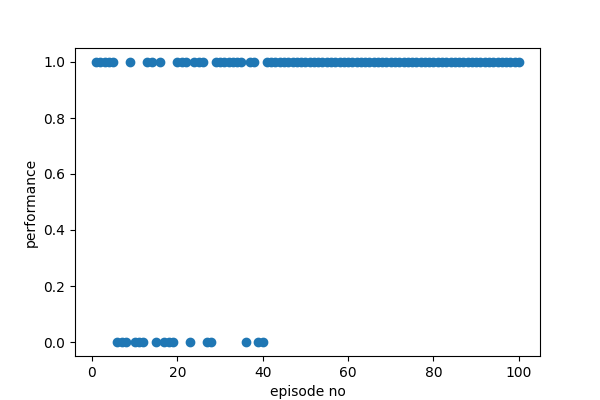

Episode numbers SIMULATION cluster gaps: (array([ 5,  6,  7,  9, 10, 11, 14, 16, 17, 18, 22, 26, 27, 35, 38, 39]),)
Number of performance deviations: 16
Initial episode number of performance block: 7
Number of in-cluster performance deviations: 13



SIMULATION FOR k: 0.15


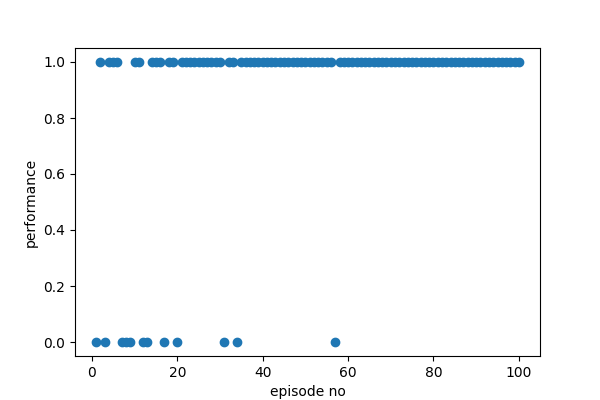

Episode numbers SIMULATION cluster gaps: (array([ 0,  2,  6,  7,  8, 11, 12, 16, 19, 30, 33, 56]),)
Number of performance deviations: 12
Initial episode number of performance block: 8
Number of in-cluster performance deviations: 7



SIMULATION FOR k: 0.20


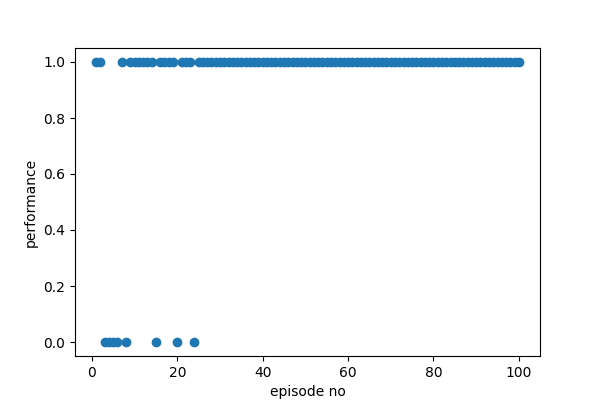

Episode numbers SIMULATION cluster gaps: (array([ 2,  3,  4,  5,  7, 14, 19, 23]),)
Number of performance deviations: 8
Initial episode number of performance block: 5
Number of in-cluster performance deviations: 4



SIMULATION FOR k: 0.25


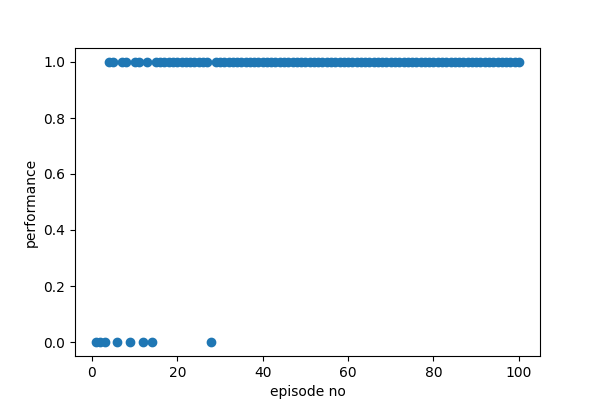

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  2,  5,  8, 11, 13, 27]),)
Number of performance deviations: 8
Initial episode number of performance block: 2
Number of in-cluster performance deviations: 5



SIMULATION FOR k: 0.30


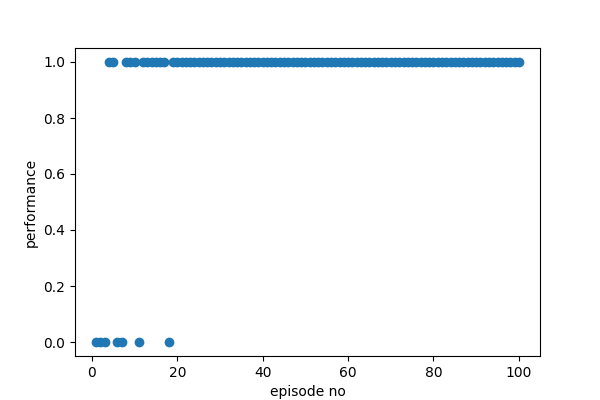

Episode numbers SIMULATION cluster gaps: (array([ 0,  1,  2,  5,  6, 10, 17]),)
Number of performance deviations: 7
Initial episode number of performance block: 2
Number of in-cluster performance deviations: 4



SIMULATION FOR k: 0.35


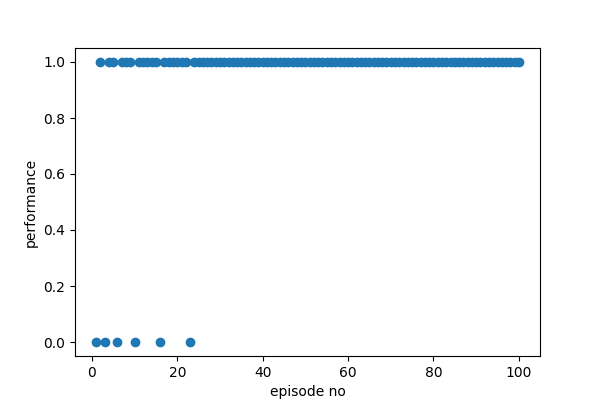

Episode numbers SIMULATION cluster gaps: (array([ 0,  2,  5,  9, 15, 22]),)
Number of performance deviations: 6
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 6



SIMULATION FOR k: 0.40


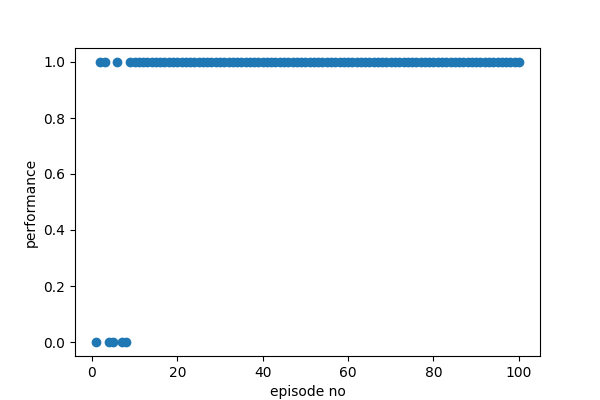

Episode numbers SIMULATION cluster gaps: (array([0, 3, 4, 6, 7]),)
Number of performance deviations: 5
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 5



SIMULATION FOR k: 0.45


/tmp/ipykernel_531/2141654931.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,4))


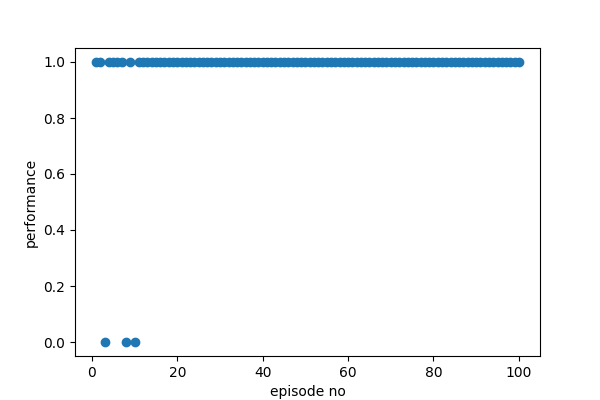

Episode numbers SIMULATION cluster gaps: (array([2, 7, 9]),)
Number of performance deviations: 3
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 3



SIMULATION FOR k: 0.50


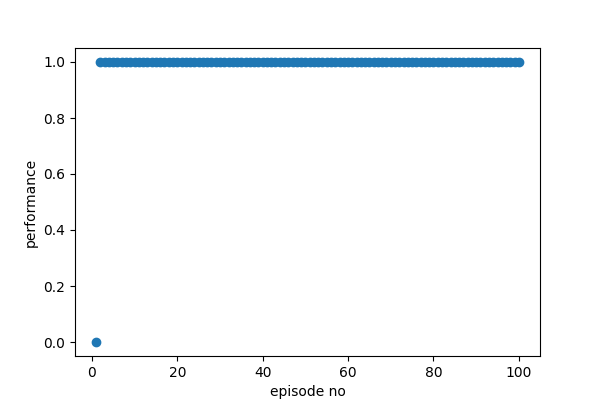

Episode numbers SIMULATION cluster gaps: (array([0]),)
Number of performance deviations: 1
No deviation block! Performance block starts from the beginning.
Number of in-cluster performance deviations: 1





In [12]:
notebook_path = os.path.abspath("MainNotebook.ipynb") # find the actual path of the Python notebook

# Define "deviations" finding the first and the last episode numbers of all performance deviation ranges
def deviations(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

# Set the total number of episodes in each simulation
nOfEpisodes = 100 # since in human experiments it is 100.
episodeAxis = np.linspace(1,nOfEpisodes,nOfEpisodes, dtype=int) # for the x axes of performance result plots

## Import the experimental data
# experimentData = scipy.io.loadmat('workspace_scriptGeneralH210528.mat')

## Load and arrange the experimental human performance data
# subject7 = experimentData['Performance'][0][6]
# subject7 = subject7[~np.isnan(subject7)]
# subject7 = subject7[(1 >= subject7) & (subject7 >= 0)]
# subject7 = subject7.flatten()
# subject7 = subject7[0:nOfEpisodes]

# Load the simulation performance data
kSet = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50] # simulated k values

inClusterSet = [] # initialize an array to save number of in-cluster performance deviations for future plots

for kVal in kSet:
    kIter = kVal*1000 # to avoid rounding in the title of the data file (only for Python convention)
    path = os.path.join(os.path.dirname(notebook_path), \
            "showcaseData/showcase_2_H0/varying_k/performanceResults_Iter_0_k_%d.npy" %kIter) # set the data file path
    simulationData = np.load(path) # load the simulation result of the corresponding k
    simulationData = simulationData[0:nOfEpisodes] # take only the first 100 episodes!
    
    # Plot the performance results episode-by-episode
    print('SIMULATION FOR k: %.2f' %kVal)
    fig = plt.figure(figsize=(6,4))
    plt.scatter(episodeAxis, simulationData)
    plt.xlabel("episode no")
    plt.ylabel("performance")
    plt.show()
    
    # Episode numbers of the performance deviations...
    # print('Episode numbers of EXPERIMENT cluster gaps:', np.where(subject7 < 1)) #...of the human experiments
    print('Episode numbers SIMULATION cluster gaps:', np.where(simulationData < 1)) #...of the simulations
    print('Number of performance deviations:', len(np.where(simulationData < 1)[0])) # total number of performance deviations (simulations)
    
    deviationsAll = np.where(simulationData < 1) # performance deviation episode numbers
    devRanges = deviationsAll[0] # jsut for Python convention
    devRanges = deviations(devRanges) # performance deviation ranges to find deviation blocks (thus initial episode number of performance blocks)
    # print(devRanges) # the first and last episode numbers of deviation blocks
    
    # Arrange the performance deviation ranges
    firstEpisode = []
    lastEpisode = []

    for element in devRanges:
        firstEpisode.append(element[0]) # keep the first
        lastEpisode.append(element[1]) # keep the second
  
    # Find the last deviation block, the last episode number of this block is the initial episode number of the performance block
    devBlockIndices = list(np.where(np.subtract(lastEpisode, firstEpisode)>=2))
    
    # Check if there is any deviation block. If not, the whole experiment is actually a performance block! Save also the in-cluster performance deviations.
    if len(devBlockIndices[0]>0):
        initialPerformanceBlock = devBlockIndices[-1][0]
        devRanges = list(devRanges)
        initialPerformanceBlock = devRanges[initialPerformanceBlock][1]   
        numberOfInClusterDeviations = len(np.where(deviationsAll>initialPerformanceBlock)[0]) # find the number of in-cluster performance deviations
        inClusterSet.append(numberOfInClusterDeviations) # save the number of in-cluster performance deviations for future plots
        # Print now also the initial episode number of the performance blocks
        print('Initial episode number of performance block:', initialPerformanceBlock)
        print('Number of in-cluster performance deviations:', numberOfInClusterDeviations)
    else:
        noDeviationBlock = len(np.where(simulationData < 1)[0][:])
        inClusterSet.append(noDeviationBlock)
        print('No deviation block! Performance block starts from the beginning.')
        print('Number of in-cluster performance deviations:', noDeviationBlock)
    

    print('')    
    print('')
    print('')


As expected, increasing  $k$  results in a decreasing trend in the initial number of performance block, that is, the model learns more and more quickly as $k$ increases; see the following plot:

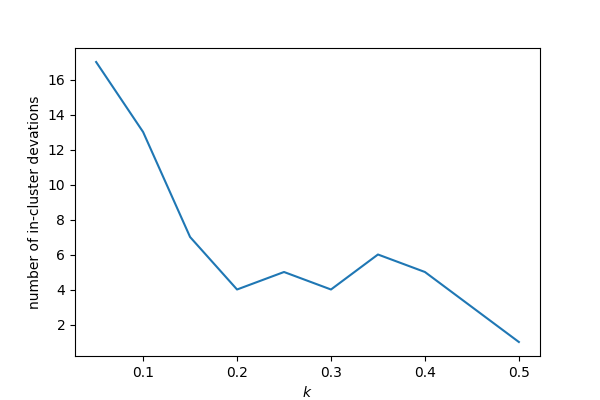

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(kSet, inClusterSet)
plt.xlabel("$k$")
plt.ylabel("number of in-cluster devations")
plt.show()

## Case study 3: effect of decision threshold on reaction time
Each cortical column is composed of a pair of excitatory and inhibitory neuronal populations, and in our model framework, each column makes the decision in favor of the stimulus which it is sensitive to. A column is represented as pool of pair of excitatory and inhibitory populations of mean-field AdEx equations in the model. Decision is made through bicolumnar competition between those two pool. It is made by the winning pool at the instant where the difference between the excitatory population firing rates exceeds a certain threshold, which we call decision threshold and which we fix to a convenient value. The decision threshold is directly related to the reaction time of the model, which is the time duration between the moment where the stimuli are shown on the screen, and the decision is made by the model.

Here we will see this relation between the decision threshold and the reaction time by focusing on single trial. We simulate a single trial via:

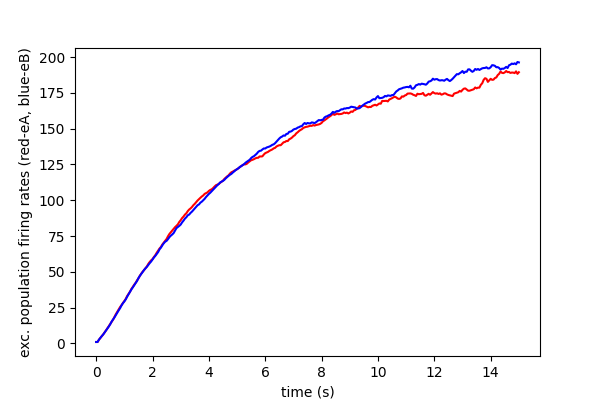

In [14]:
# Define the stimuli for one trial
from scipy.special import comb

def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

t = np.linspace(0, tF, int(tF/dt)+1) # define the whole time interval


ampA = 1    # amplitude of stimulus A
ampB = 10   # amplitude of stimulus B
t0 = 2 # initial time instant of the stimuli


stimulusA = ampA*(smoothstep(t-t0)-smoothstep(t-t0-tF))
stimulusB = ampB*(smoothstep(t-t0)-smoothstep(t-t0-tF))

## Build the simulation setup: load the transfer functions for both RS & FS populations
TF1, TF2 = LoadTransferFunctions('RS-cell', 'FS-cell', 'CONFIG1')
lambdaA, lambdaB, psi = RegulatoryPsi(psi0, stimulusA, stimulusB, params) # generate the regulated stimuli for the trial

# Time integration for one single trial
state = TimeStepping(V0, lambdaA, lambdaB, TF1, TF2, params)

# Plot Pool A (red) and B (blue) excitatory population firing rates
fig = plt.figure(figsize=(6,4))
plt.plot(t, state[:, 0], 'r') # plotting v_{eA} (red)
plt.plot(t, state[:, 7], 'b') # plotting v_{eB} (blue)
plt.xlabel("time (s)")
plt.ylabel("exc. population firing rates (red-eA, blue-eB)")
# plt.margins(x=0.001, y=-0.001)
plt.show()

In [15]:
veA, veB = state[:, 0], state[:, 7]
decisionThreshold = 3 # the decision is made once the absolute value of the difference between excitatory population firing rates exceeds this value.


# Find the reaction time
diff = np.abs(veA - veB) # compute the difference between the excitatory populations
diff2 = diff[int(2/dt):-1] # ignore the first instants of the trial since the activity is degenerate the beginning
decisionIndex = np.where(diff2>decisionThreshold) # identify the time instant at which the decision is made (bicolumnar competition is assumed to end at this instant)   
decisionTime = (decisionIndex[0][0]) * dt # pick the first instant where the difference exceeds dec. threshold
# decisionTimeList[episodeNo] = decisionTime
print('Decision is made at: %.2f s' % decisionTime)                

Decision is made at: 1.00 s


Let us see now how the trend of decision time looks like with respect to varying decision threshold.

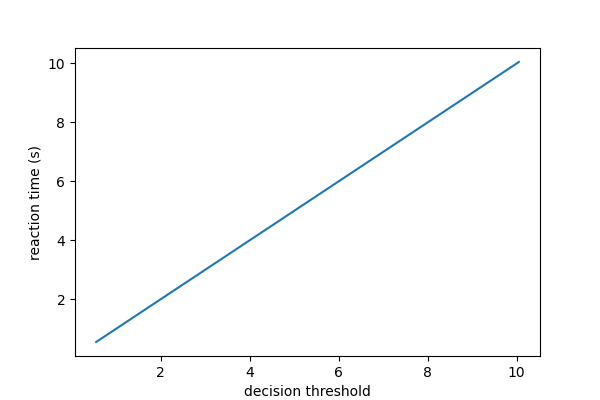

In [16]:
inThreshold = 2 # initial decision threshold value
finThreshold = 10 # final decision threshold value
nOfSamples = 20 # number of samples of threshold values between the initial and final values
decisionThresholdList = np.linspace(inThreshold, finThreshold, nOfSamples) # create the list of threshold samples

decisionTimeList = [] # initialize reaction time list

# Find the reaction time for each threshold value
diff = np.abs(veA - veB) # compute the difference between the excitatory populations
diff2 = diff[int(2/dt):-1] # ignore the first instants of the trial since the activity is degenerate the beginning

for decisionThreshold in decisionThresholdList:
    decisionIndex = np.where(diff2>decisionThreshold) # identify the time instant at which the decision is made (bicolumnar competition is assumed to end at this instant)   
    decisionTime = (decisionIndex[0][0]) * dt # pick the first instant where the difference exceeds dec. threshold
    decisionTimeList.append(decisionTime)

# Plot the reaction time with respect to increasing decision threshold values 
fig = plt.figure(figsize=(6,4))
plt.plot(decisionTimeList, decisionTimeList)
plt.xlabel("decision threshold")
plt.ylabel("reaction time (s)")
# plt.margins(x=0.001, y=-0.001)
plt.show()


As expected, reaction time increases as the decision threshold increases. Moreover, the relation has a rather linear character.

## Bibliography
[1]: M. di Volo, A. Romagnoni, C. Capone, A. Destexhe, "Biologically realistic mean-field models of conductance-based networks of spiking neurons with adaptation", Neural Computation, vol. 31, no. 4, pp. 653-680, 2019.

[2]: R. Brette, W. Gerstner, "Adaptive exponential integrate-and-fire model as an effective description of neuronal activity", Journal of Neurophysiology, vol. 94, no. 5, pp. 3637-3642, 2005.

[3]: S. El Boustani, A. Destexhe, "A master equation formalism for macroscopic modeling of asynchronous irregular activity states", Neural Computation, vol. 21, no. 1, pp.46-100, 2009. 

[4]: Y. Zerlaut, S. Chemla, F. Chavane, A. Destexhe, "Modeling mesoscopic cortical dynamics using a mean-field model of conductance-based networks of adaptive exponential integrate-and-fire neurons", Journal of Computational  Neuroscience, vol. 44, no. 1, pp. 45-61, 2018.

[5]: E. Baspinar, G. Cecchini, M. DePass, I. Cos, R. Moreno-Bote, A. Destexhe, "Biophysically realistic AdEx mean-field model for reward-driven consequential decision-making", Poster, FENS 2022 (Federation of European Neuroscience Societies 2022), Paris.